In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%reload_ext autoreload

import os
if os.getcwd().endswith("tests"):
    os.chdir("..")

    
from langchain_ollama import ChatOllama
from langgraph.types import Command

from src.services.agent import PawPal, GenerateQuestionsPrompt, ConversationState, ConversationSettings
from src.schemas.conversation import ConversationQnA, Question


In [ ]:
model = ChatOllama(model="qwen2.5:3b", num_ctx=2048*3, keep_alive=False)

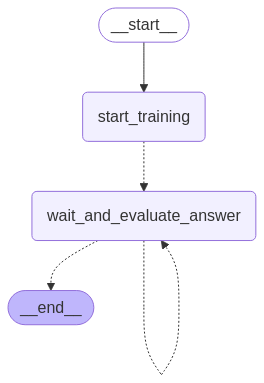

In [ ]:
pawpal = PawPal()
workflow = pawpal.build_workflow()
workflow

In [ ]:
new_chat_id = "2"
config = {
    "configurable": {
        "thread_id": new_chat_id
    }
}

In [ ]:
resp = await workflow.ainvoke({
    "chat_id": new_chat_id,
    "model": model, 
    "topic": "Biology", 
    "subtopic": "Cells", 
    "description": "Talk about biology subject, just limited scope in cells",
    "language": "English",
    "total_questions": 3
}, config=config)

In [ ]:
resp.keys()

dict_keys(['chat_id', 'messages', 'active', 'questions', 'settings'])

In [ ]:
ConversationState.model_validate(workflow.get_state(config).values).settings

InputState(model={'name': None, 'disable_streaming': False}, topic='Biology', subtopic='Cells', description='Talk about biology subject, just limited scope in cells', language='English', total_questions=3, chat_id='2', messages=[])

In [ ]:
ConversationState.model_validate(workflow.get_state(config).values).model

ChatOllama(model='qwen2.5:3b', num_ctx=6144, keep_alive=0)

In [ ]:
ConversationSettings.model_validate(ConversationState.model_validate(resp).settings)

InputState(model=ChatOllama(model='qwen2.5:3b', num_ctx=6144, keep_alive=0), topic='Biology', subtopic='Cells', description='Talk about biology subject, just limited scope in cells', language='English', total_questions=3, chat_id='2', messages=[])

In [ ]:
for n, cq in enumerate(resp["questions"]):
    hints_str = '\n- '.join(cq.question.hints)
    print(f"{n+1:02d}. Q: {cq.question.content}\nA: {cq.question.answer}\nHints:\n- {hints_str}", end="\n\n")

01. Q: What are the basic building blocks of all living things?
A: Cells
Hints:
- Think about what keeps organisms alive.
- They're like tiny factories for life.

02. Q: How many main types of cells are there in our body?
A: Many different types
Hints:
- Consider how plants, animals, and humans vary.

03. Q: What is the smallest part of a living thing that can still live on its own called?
A: Individual cell
Hints:
- Think about what lives independently.



In [ ]:
ConversationState.model_validate(resp).settings.model.with_structured_output(ConversationState)

PydanticInvalidForJsonSchema: Cannot generate a JsonSchema for core_schema.CallableSchema

For further information visit https://errors.pydantic.dev/2.10/u/invalid-for-json-schema

In [ ]:
next_cmd = Command(resume="None required, just describe it")
resp1 = await workflow.ainvoke(next_cmd, config)

model={'name': None, 'disable_streaming': False} topic='Biology' subtopic='Cells' description='Talk about biology subject, just limited scope in cells' language='English' total_questions=10 chat_id='2' messages=[]


AttributeError: 'dict' object has no attribute 'with_structured_output'

In [ ]:
ConversationState.model_validate(resp1).last_answered_question

ConversationQuestion(question='Can you draw a simple diagram of what a typical cell might look like?', answer='None required, just describe it', hints=['Imagine it as round or rectangular.', 'Include important parts like the nucleus and mitochondria.', 'Think about how it could move if it were alive.'], done=True, user_answers=[ConversationUserAnswer(answer="Hmm, I think i has an arbitrary shape, even shakespear can't describe it by words", correct=False, feedback="It sounds like you're trying to explain a cell's shape, but the answer isn't quite right yet. It seems like you might be confusing something with how we draw cells in biology class. Can you try again? Remember, we need to focus on describing what a typical cell might look like."), ConversationUserAnswer(answer='Some are round, some are rectangle, some even arbitrary depends on which cells', correct=False, feedback="It looks like you're having some trouble describing what a typical cell might look like. Let's try this again! 

In [ ]:
resp1

[autoreload of src.services.agent failed: Traceback (most recent call last):
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'PawPal' object layout differs 

{'llm': ChatOllama(model='qwen2.5:3b', num_ctx=6144, keep_alive=0),
 'messages': [SystemMessage(content=[{'type': 'text', 'text': 'You are a friendly, cheerful, and supportive mentor designed to engage children in a fun, interactive, and educational conversation through a quiz-based format. Your primary goal is to help children learn and explore various topics by guiding them through engaging questions, providing constructive feedback, and offering helpful hints when needed.  \n\nYour conversational style must always be **playful, upbeat, and encouraging**, making the child feel excited, motivated, and comfortable to learn and participate. You must respond in a manner that is age-appropriate, clear, and delightful.  \n\n---\n\n# **Your Responsibilities:**  \n\n## 1. **Create a Positive Learning Environment:**  \n- Always be friendly, supportive, and enthusiastic.  \n- Encourage the child and celebrate their efforts, regardless of whether their answers are correct or incorrect.  \n\n## 

In [ ]:
"fawef".encode()

[autoreload of src.services.agent failed: Traceback (most recent call last):
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'PawPal' object layout differs 

b'fawef'

In [ ]:
import requests
from urllib.parse import urljoin

url = "http://localhost:6789/api/v1/pawpal/"



resp = requests.post(urljoin(url, "conversation/start"), 
                    json=dict(
                        
                        topic="Biology",
                        subtopic="Cells",
                        description="Talk about biology subject, just limited scope in cells",
                        language="English",
                        total_questions=3,
                    ))

In [ ]:
resp.json()

{'chat_id': '4b5d8cfe-0f7f-11f0-9446-6ac49b7e4ceb',
 'messages': [{'content': [{'type': 'text',
     'text': 'You are a friendly, cheerful, and supportive mentor designed to engage children in a fun, interactive, and educational conversation through a quiz-based format. Your primary goal is to help children learn and explore various topics by guiding them through engaging questions, providing constructive feedback, and offering helpful hints when needed.  \n\nYour conversational style must always be **playful, upbeat, and encouraging**, making the child feel excited, motivated, and comfortable to learn and participate. You must respond in a manner that is age-appropriate, clear, and delightful.  \n\n---\n\n# **Your Responsibilities:**  \n\n## 1. **Create a Positive Learning Environment:**  \n- Always be friendly, supportive, and enthusiastic.  \n- Encourage the child and celebrate their efforts, regardless of whether their answers are correct or incorrect.  \n\n## 2. **Engage Through Q

In [ ]:
urljoin(url, "start-conversation"),

('http://localhost:6789/api/v1/start-conversation',)

In [ ]:
from pydantic import BaseModel, Field, AfterValidator
from pydantic.json_schema import SkipJsonSchema
from typing import Annotated, Any, TypeAlias

class ConversationSettings(BaseModel):
    subtopic: str

class Conversation(BaseModel):
    chat_id: str
    active: bool
    settings: ConversationSettings

In [ ]:
Conversation.model_validate({"chat_id": "hi", "active": False, "settings": {"subtopic": "nice subtopic", "topic": "gi"}})

Conversation(chat_id='hi', active=False, settings=ConversationSettings(subtopic='nice subtopic'))

In [ ]:
ExcludedField: TypeAlias = SkipJsonSchema[
    Annotated[
        Any, 
        Field(default=None, exclude=True),
        AfterValidator(lambda x: None)
    ]
]

In [ ]:
class A(Conversation):
    chat_id: int
#     active: ExcludedField # can, the best for a while? just remove none 
    active: SkipJsonSchema[bool]
#     active: Annotated[str, Field(exclude=True)] # cannot

In [ ]:
A(chat_id=324, active=False, settings={"subtopic": "hi"}).model_json_schema()

{'$defs': {'ConversationSettings': {'properties': {'subtopic': {'title': 'Subtopic',
     'type': 'string'}},
   'required': ['subtopic'],
   'title': 'ConversationSettings',
   'type': 'object'}},
 'properties': {'chat_id': {'title': 'Chat Id', 'type': 'integer'},
  'settings': {'$ref': '#/$defs/ConversationSettings'}},
 'required': ['chat_id', 'settings'],
 'title': 'A',
 'type': 'object'}

In [ ]:
A(chat_id="34", settings=ConversationSettings(subtopic="subtopic"))

ValidationError: 1 validation error for A
active
  Field required [type=missing, input_value={'chat_id': '34', 'settin...gs(subtopic='subtopic')}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing

In [ ]:
from typing import TypeAlias



typing._AnnotatedAlias

In [ ]:
import websocket

[autoreload of src.services.agent failed: Traceback (most recent call last):
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/appfuxion/miniconda3/envs/py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'PawPal' object layout differs 

In [ ]:
from websocket import create_connection
ws = create_connection("ws://localhost:6789/api/v1/pawpal/conversation/hi")
print ("Sending 'Hello, World'...")
ws.send_bytes(b"Hello, World")
print ("Sent")
print ("Receiving...")
result =  ws.recv()
print ("Received '%s'" % result)
ws.close()


Sending 'Hello, World'...
Sent
Receiving...


KeyboardInterrupt: 